# ARM Open-Science with CRG and BSEC (MSDLive) Data

<table>
    <tr>
        <td>
            <img src="https://www.arm.gov/wp-content/uploads/54251180546_1125c8161e_c-768x577.jpg" style="height: 300px;" alt="CRG Campaign"></img>
        </td>
        <td>
            <h1>Atmospheric Radiation Measurement user facility (ARM)</h1>
            <h1>Coast-Urban-Rural Atmospheric Gradient Experiment(CRG)</h1>
            Notebook showing how to download and visualize data from ARM and MSDLive for the CoURAGE and BSEC campaigns. </br>
            Corresponding Author: Adam Theisen (atheisen@anl.gov)
        </td>
    </tr>
</table>

## Overview
The first ARM Mobile Facility (AMF1) is deployed to 3 sites around the Baltimore, MD region beginning December 1, 2024.  As the name implies, the 3 sites cover coastal (supplemental site S3), urban (main site M1), and rural (supplemental site S2).  This tutorial will help users download and visualie both ARM and the BSEC doppler lidar datasets.

## Prerequisites
This notebook will rely heavily on Python and [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT) Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.  

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webservice information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.


| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |

- **Time to learn**: 15 Minutes

---

## ARM and BSEC Doppler Lidar Data
The doppler lidar (DL) is an active remote-sensing instrument that provides range- and time-resolved measurements of radial velocity abd attenuated aerosol backscatter.  More information can be found on ARM's [DL instrument page](https://arm.gov/capabilities/instruments/dl).
### Import Libraries

In [28]:
# Install dependencies from requirements.txt (silent)
!pip install -r requirements.txt > /dev/null

In [29]:
# Import Libraries
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import act
from pathlib import Path

### Read data in using xarray
This is a great example of using the tools that work for what you need in Python.  Xarray works just fine to open up these files and get them into a dataset that can be used by ACT.

### Download ARM DL Data
As a reminder, you will need a username and token.  See prerequisites for details on how to get one from ARM.

In [38]:
# And download the ARM data
# Set the datastream and start/enddates
datastream = 'crgdlfptS2.b1'
startdate = '2024-12-24'
enddate = '2024-12-24T23:59:59'

# Set your username and token here!
username = 'ARM_username'
token = 'ARM_token'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result_dl = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] crgdlfptS2.b1.20241224.000018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.010019.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.020018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.030017.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.040018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.050019.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.060019.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.070018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.080018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.090018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.100018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.110018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.120017.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.130018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.140017.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.150019.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.160018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.170017.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.180018.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.190019.cdf
[DOWNLOADING] crgdlfptS2.b1.20241224.200

In [47]:
# Let's find the vertical stare data and read it in with xarray
# Anything xarray dataset will work with ACT
from pathlib import Path
data_dir = Path(os.environ['DATA_DIR'])
search_path = data_dir / '01_Vertical_Stare_Scans' / 'data_stare' / '2024' 
files = list(search_path.glob('*20241224*.nc'))

ds_bsec_dl = xr.open_mfdataset(files)

### Read ARM Data Using ACT

In [48]:
ds_arm_dl = act.io.read_arm_netcdf(result_dl)

/opt/conda/lib/python3.11/site-packages/act/io/arm.py:155: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(filenames, **kwargs)


### Resample Data to 30-Second Resolution
This is to help with future plotting and work with the data

In [49]:
ds_arm_dl = ds_arm_dl.resample(time='30s').nearest()
ds_bsec_dl = ds_bsec_dl.resample(time='30s').nearest()

ds_arm_dl = ds_arm_dl.where(ds_arm_dl.range > 45.)
ds_bsec_dl = ds_bsec_dl.where(ds_bsec_dl.range > 45.)

### Plot ARM and BSEC Data Together Using ACT

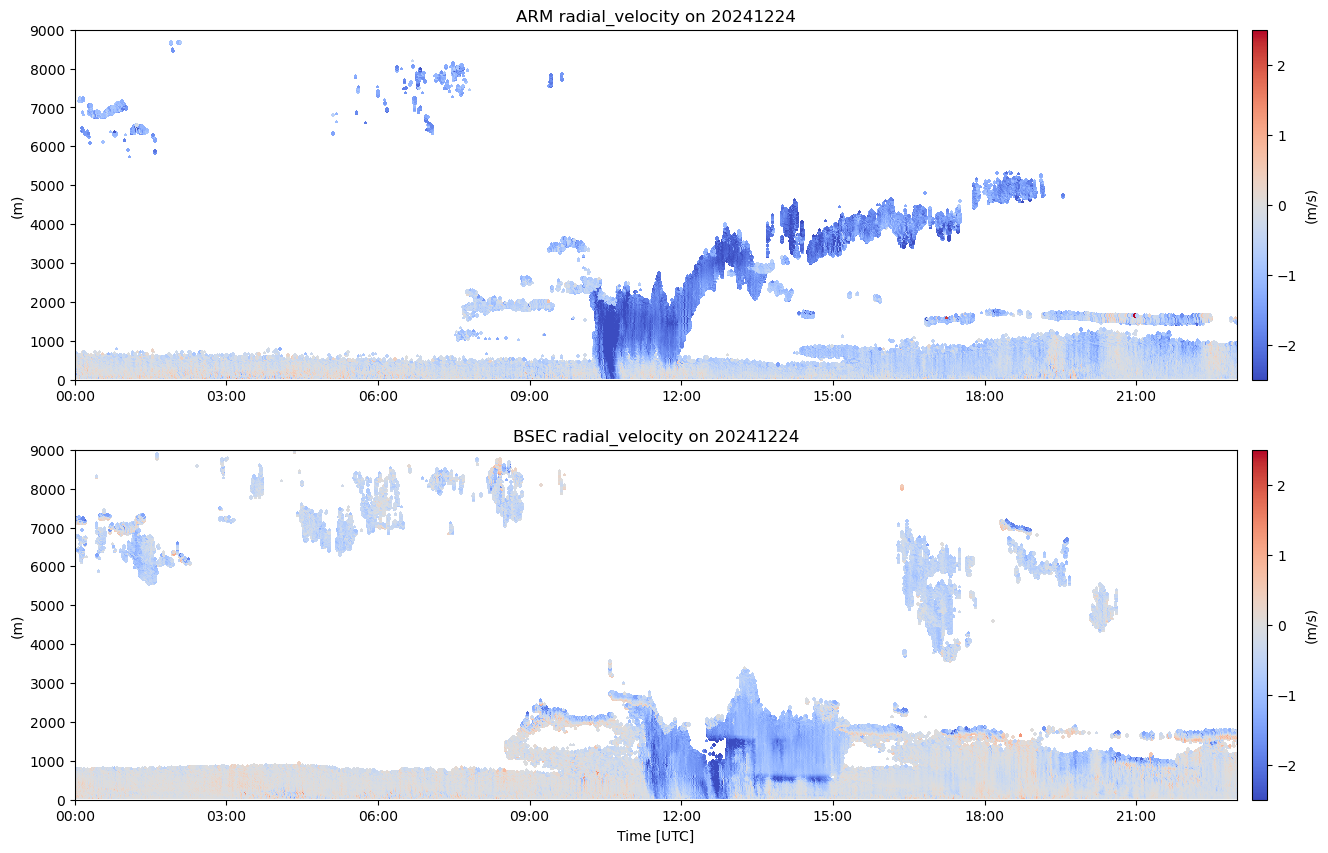

In [50]:
# First, let's subset the data to remove some of the noise
ds_arm_dl = ds_arm_dl.where(ds_arm_dl['intensity'] > 1.02)
ds_bsec_dl = ds_bsec_dl.where(ds_bsec_dl['intensity'] > 1.02)

display = act.plotting.TimeSeriesDisplay({'ARM': ds_arm_dl, 'BSEC': ds_bsec_dl}, figsize=(15,10), subplot_shape=(2,))
display.plot('radial_velocity', dsname='ARM', subplot_index=(0,), cmap='coolwarm', vmin=-2.5, vmax=2.5)
display.plot('radial_velocity', dsname='BSEC', subplot_index=(1,), cmap='coolwarm', vmin=-2.5, vmax=2.5)
display.set_yrng([0, 9000], subplot_index=(0,))
display.set_yrng([0, 9000], subplot_index=(1,))

### Plot up Mean Profiles of Radial Velocity Using Matplotlib
The great part with all these tools is the interoperability between them.  If one package does not have what you need, there is sure to be another.

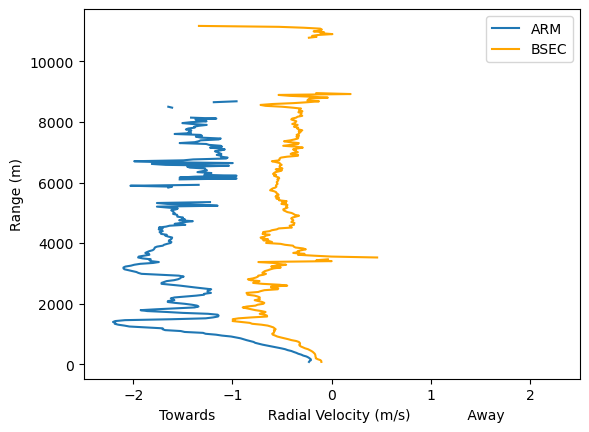

In [51]:
# Let's plot some time-height average profiles of the data
fig, ax = plt.subplots()
ax.plot(ds_arm_dl.radial_velocity.mean(axis=0), ds_arm_dl.range, label='ARM')
ax.plot(ds_bsec_dl.radial_velocity.mean(axis=0), ds_bsec_dl.range, color='orange', label='BSEC')
ax.set_xlabel('Towards            Radial Velocity (m/s)             Away')
ax.set_ylabel('Range (m)')
ax.set_xlim([-2.5, 2.5])

# If you want to just look at the boundary lay you can update the y-limits
#ax.set_ylim([0, 1000.])

plt.legend()

## Summary
This notebook should have shown you the basics of downloading and visualizing doppler lidar data from BSEC and ARM and ways of using different python libraries in conjunction with ACT.  Additional notebooks will be made available in the future for other instrument comparisons.

### Data Used in this Notebook
Newsom, R., Shi, Y., & Krishnamurthy, R. Doppler Lidar (DLFPT), 2025-01-10 to 2025-01-10, ARM Mobile Facility (CRG), Baltimore, MD; Supplemental Facility 2 in rural setting (S2). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1025185

Prince, N. E., Miller, D. O., Ahlswede, B., Li, X., Collins, S. P., Haupt, B., Miles, N. L., Richardson, S. J., & Davis, K. J. (2025). Baltimore Social-Environmental Collaborative (BSEC) Doppler Lidar & Derived Products (v2.0.0) [Data set]. MSD-LIVE Data Repository. https://doi.org/10.57931/2568764